# Split-Brain AutoEncoders

In [ ]:
import os
import tqdm.notebook as tqdm
from typing import Any, List, Dict, Callable

import kornia
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

sns.set_theme()
sns.set_palette('Set1')

%matplotlib inline
%config InlineBackend.figure_formats = ['pdf', 'svg']

root = os.getcwd()

In [ ]:
# downloading files from kaggle

import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

## STL-10 Dataset

In [3]:
class STLDataset(Dataset):

    def __init__(self, root: str, preprocess: Callable, downsample_size: int,
                 L_bins: int, ab_bins: int, split: str = 'unlabeled') -> None:
        super().__init__()
        self.root = root                                            # image dataset directory
        self.preprocess = preprocess                                # lab preprocessing
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)   # downsampling resizer
        self.L_bins = L_bins                                        # Num of bucketizing L bins
        self.ab_bins = ab_bins                                      # Num of bucketizing ab bins
        self.stl_dataset = STL10(root=root, split=split, download=True)
        self.requires_downsample = split == 'unlabeled'
    
    def __len__(self) -> int:
        return len(self.stl_dataset)

    def normalize_lab(self, x: torch.tensor):
        x[0, :, :] = x[0, :, :] / 100.
        x[1, :, :] = (x[1, :, :] + 87.) / (99+87)
        x[2, :, :] = (x[2, :, :] + 108.) / (95+108)
        return x

    def denormalize_lab(self, x: torch.tensor):
        x[:, 0, :, :] = x[:, 0, :, :] * 100.
        x[:, 1, :, :] = (x[:, 1, :, :] * (99.+ 87.)) - 87
        x[:, 2, :, :] = (x[:, 2, :, :] * (95.+ 108.)) - 108
        return x
    
    def __getitem__(self, index: int) -> Any:

        image, label = self.stl_dataset[index]                  # RGB: (3, H, W)
        preprocessed = self.preprocess(image)                   # LAB: (3, H, W)

        # normalized train image
        normalized = self.normalize_lab(preprocessed)

        if self.requires_downsample:

            # downsampling original image
            downsample = self.resize(preprocessed)                  # LAB: (3, D, D)

            # bucketizing
            # L in [0, 100]
            # a in [-87, 99]
            # b in [-108, 95]
            L_target = torch.bucketize(downsample[0, :, :], boundaries=torch.linspace(0, 101, self.L_bins+1), right=True) - 1
            a_target = torch.bucketize(downsample[1, :, :], boundaries=torch.linspace(-87, 99, self.ab_bins+1), right=True) - 1
            b_target = torch.bucketize(downsample[2, :, :], boundaries=torch.linspace(-108, 95, self.ab_bins+1), right=True) - 1
            ab_target = a_target * self.ab_bins + b_target

            ds_elem = {
                'image': image,
                'train': normalized,
                'L_target': L_target.type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor),
                'ab_target': ab_target.type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor)
            }
            return ds_elem

        ds_elem = {
            'image': image,
            'label': label,
            'train': normalized,
        }
        return ds_elem

In [4]:
def collate_fn_unsup(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    data = {}
    data['image'] = [elem['image'] for elem in batch]
    data['train'] = torch.stack([elem['train'] for elem in batch])
    data['L_target'] = torch.stack([elem['L_target'] for elem in batch])
    data['ab_target'] = torch.stack([elem['ab_target'] for elem in batch])
    return data

def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    data = {}
    data['image'] = [elem['image'] for elem in batch]
    data['label'] = torch.tensor([elem['label'] for elem in batch]).type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor)
    data['train'] = torch.stack([elem['train'] for elem in batch])
    return data

preprocess = transforms.Compose([
    transforms.ToTensor(),
    kornia.color.rgb_to_lab
])

In [5]:
stl_dataset = STLDataset(root, preprocess, downsample_size=12, L_bins=100, ab_bins=25)
train_ds, val_ds = torch.utils.data.random_split(stl_dataset, [0.9, 0.1])

100%|██████████| 2640397119/2640397119 [01:57<00:00, 22408098.53it/s]


Extracting /kaggle/working/stl10_binary.tar.gz to /kaggle/working


In [7]:
train_dl = DataLoader(train_ds, 64, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, 64, shuffle=False, collate_fn=collate_fn)

## AlexNet + SB AE + Classifier

In [5]:
class AlexNetEncoder(nn.Module):

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.fc_encoder = nn.Sequential(
            nn.Conv2d(self.in_channels, 96, kernel_size=10, stride=2, padding=1, bias=False),   # [batch, 96, 45, 45]
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=1),                       # [batch, 96, 23, 23]
            nn.Conv2d(96, 256, kernel_size=5, dilation=1, padding=2, bias=False),               # [batch, 256, 23, 23]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=1),                       # [batch, 256, 12, 12]
            nn.Conv2d(256, 384, kernel_size=3, dilation=1, padding=1, bias=False),              # [batch, 384, 12, 12]
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, dilation=1, padding=1, bias=False),              # [batch, 384, 12, 12]
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, dilation=1, padding=1, bias=False),              # [batch, 256, 12, 12]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, dilation=1, padding=1),                       # [batch, 256, 12, 12]
            nn.Conv2d(256, 4096, kernel_size=7, dilation=2, padding=6, bias=False),             # [batch, 4096, 12, 12]
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True),
            nn.Conv2d(4096, 4096, kernel_size=1, dilation=1, bias=False),                       # [batch, 4096, 12, 12]
            nn.BatchNorm2d(4096),
            nn.ReLU(inplace=True),
            nn.Conv2d(4096, self.out_channels, kernel_size=1, dilation=1),                      # [batch, out, 12, 12]
        )

    def forward(self, x: torch.tensor):
        '''
        :x: torch.tensor of shape [batch, in_channels, 96, 96]
        '''
        return self.fc_encoder(x)
    

class SBAutoEncoder(nn.Module):

    def __init__(self, L_bins: int = 100, ab_bins: int = 25) -> None:
        super().__init__()
        self.L_ab = AlexNetEncoder(1, ab_bins ** 2)
        self.ab_L = AlexNetEncoder(2, L_bins)

        print(f'Split Brain Num params: {sum(p.numel() for p in self.parameters() if p.requires_grad)}')
    
    def forward(self, x: torch.tensor):
        '''
        :x: torch.tensor of shape [batch, 3, 96, 96]
        '''
        x1, x2 = x[:, 0, :, :].unsqueeze(1), x[:, 1:, :, :]
        x2_hat = self.L_ab(x1)
        x1_hat = self.ab_L(x2)

        return x1_hat, x2_hat


class Classifier(nn.Module):

    def __init__(self, sbae_weights_path: str, last_layer_ind: int = 8, input_size: int = 5*5*384*2,
                 n_classes: int = 10, hidden_size: int = 1000, downsample_size: int = 5, **kwargs) -> None:
        super().__init__()

        # pretrained SplitBrainAE
        self.sb_ae = SBAutoEncoder(**kwargs)
        self.sb_ae.load_state_dict(torch.load(sbae_weights_path))

        # freezing weights
        for param in self.sb_ae.parameters():
            param.requires_grad = False
        
        self.last_layer_ind = last_layer_ind
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)

        # fc classification head
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, n_classes),
        )

    def forward(self, x: torch.tensor):
        x1, x2 = x[:, 0, :, :].unsqueeze(1), x[:, 1:, :, :]

        # slicing specified number of layers
        x2_hat = self.sb_ae.L_ab.fc_encoder[:self.last_layer_ind+1](x1)                 # [batch, N, 12, 12]
        x1_hat = self.sb_ae.ab_L.fc_encoder[:self.last_layer_ind+1](x2)                 # [batch, N, 12, 12]

        x = torch.cat((x1_hat, x2_hat), dim=1)                                          # [batch, 2N, 12, 12]
        x = self.resize(x).view(x.shape[0], -1)                                         # [batch, 2N * 5 * 5]

        x = self.fc(x)                                                                  # [batch, 10]

        return x

## Train Split-Brain AE

In [16]:
model_checkpoint_path = os.path.join(os.getcwd(), 'model_checkpoints')

if not os.path.exists(model_checkpoint_path):
    os.mkdir(model_checkpoint_path)

In [17]:
n_epochs = 5
max_norm = 0.5  # gradient clipping

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SBAutoEncoder().to(device).train()

scaler = torch.cuda.amp.GradScaler()

Lab_criterion = nn.CrossEntropyLoss()
abL_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 146774229


In [19]:
total_step = 0

train_loss = []
val_loss = 0
grad_norm = []

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        X, L_target, ab_target = batch['train'].to(device), batch['L_target'].to(device), \
                                 batch['ab_target']

        # Perform forward pass with mixed precision
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            L_hat, ab_hat = model(X)
            L_loss = abL_criterion(L_hat, L_target)
            ab_loss = Lab_criterion(ab_hat, ab_target)

            loss = L_loss + ab_loss

        # Perform backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            # Perform Gradient Clipping
            grad_norm.append(torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            grad_norm[(total_step - 1) % 100] = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item()

        # Perform Optimization Step
        scaler.step(optimizer)
        scaler.update()

        # Perform Scheduler Step
        if total_step % 500 == 0:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[-1]

        # validation
        if total_step % 300 == 0:

            val_loss = 0
            model.eval()

            with torch.no_grad():
                for val_batch in val_dl:
                    X, L_target, ab_target = val_batch['train'].to(device), val_batch['L_target'].to(device), \
                                             val_batch['ab_target']
                    L_hat, ab_hat = model(X)
                    val_loss += (abL_criterion(L_hat, L_target) + Lab_criterion(ab_hat, ab_target)).item()
                
                val_loss /= len(val_dl)

                # saving logs
                writer.add_scalar('Loss/Val', val_loss, global_step=total_step)

            model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, GradNorm: {1:.2e}, Train Loss: {2:.2e}, Val Loss: {3:.3f}'.format(
                current_lr, np.mean(grad_norm), np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('GradNorm', np.mean(grad_norm), global_step=total_step)
    
    # saving model
    torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'sb_encoder-{epoch}.pth'))

    writer.flush()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

## Train Classifier

In [6]:
! rm -rf /kaggle/working/model_checkpoints
! rm -rf /kaggle/working/logs

In [7]:
model_checkpoint_path = os.path.join(os.getcwd(), 'model_checkpoints')

if not os.path.exists(model_checkpoint_path):
    os.mkdir(model_checkpoint_path)

In [8]:
train_ds = STLDataset(root, preprocess, downsample_size=12, L_bins=100, ab_bins=25, split='train')
val_ds = STLDataset(root, preprocess, downsample_size=12, L_bins=100, ab_bins=25, split='test')

train_dl = DataLoader(train_ds, 64, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, 64, shuffle=False, collate_fn=collate_fn)

100%|██████████| 2640397119/2640397119 [01:07<00:00, 38945583.75it/s]


Extracting /kaggle/working/stl10_binary.tar.gz to /kaggle/working
Files already downloaded and verified


### Using Conv3 representations

In [20]:
n_epochs = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Classifier(sbae_weights_path='/kaggle/input/split-brain-pretrained/pretrained_ae/sb_encoder-4.pth').to(device).train()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 146774229


### Using Conv4 representations

In [9]:
n_epochs = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Classifier(sbae_weights_path='/kaggle/input/split-brain-pretrained/pretrained_ae/sb_encoder-4.pth',
                   last_layer_ind=11).to(device).train()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 146774229


### Using Pool5 representations

In [9]:
n_epochs = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Classifier(sbae_weights_path='/kaggle/input/split-brain-pretrained/pretrained_ae/sb_encoder-4.pth',
                   last_layer_ind=17, input_size=6*6*256*2, downsample_size=6).to(device).train()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 146774229


In [10]:
total_step = 0

train_loss = []
val_loss = 0

train_accuracy = []
val_accuracy = 0

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        X, labels = batch['train'].to(device), batch['label'].to(device)

        # Perform forward pass
        logits = model(X)
        loss = criterion(logits, labels)

        # Perform backward pass
        loss.backward()
        
        # Compute accuracy
        with torch.no_grad():
            preds = torch.argmax(logits, dim=-1)

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            train_accuracy.append(torch.mean((preds == labels).float()).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            train_accuracy[(total_step - 1) % 100] = torch.mean((preds == labels).float()).item()

        # Perform Optimization Step
        optimizer.step()

        # Perform Scheduler Step
        if total_step % 500 == 0:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[-1]

        # validation
        if total_step % 30 == 0:

            val_loss = 0
            val_accuracy = 0
            model.eval()

            with torch.no_grad():
                for val_batch in val_dl:
                    X, labels = val_batch['train'].to(device), val_batch['label'].to(device)
                    logits = model(X)
                    preds = torch.argmax(logits, dim=-1)
                    val_loss += criterion(logits, labels)
                    val_accuracy += torch.mean((preds == labels).float()).item()
                
                val_loss /= len(val_dl)
                val_accuracy /= len(val_dl)

                # saving logs
                writer.add_scalar('Loss/Val', val_loss, global_step=total_step)
                writer.add_scalar('Accuracy/Val', val_accuracy, global_step=total_step)

            model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, Accuracy Train/Val: {1:.2f}/{2:.2f}, Loss Train/Val: {3:.2f}/{4:.3f}'.format(
                current_lr, np.mean(train_accuracy), val_accuracy, np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('Accuracy/Train', np.mean(train_accuracy), global_step=total_step)
    
    # saving model
    if epoch == 4:
        torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'sb_encoder-{epoch}.pth'))

    writer.flush()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [12]:
download_file('/kaggle/working/logs', 'logs')

/kaggle/working/logs.zip

In [13]:
download_file('/kaggle/working/model_checkpoints/sb_encoder-4.pth', 'out')

/kaggle/working/out.zip

### T-SNE on Pool5 representations

In [67]:
class SBEncoder(nn.Module):

    def __init__(self, sbae_weights_path: str, last_layer_ind: int = 17, input_size: int = 6*6*256*2,
                 downsample_size: int = 6, **kwargs) -> None:
        super().__init__()

        # pretrained SplitBrainAE
        self.sb_ae = SBAutoEncoder(**kwargs)
        self.sb_ae.load_state_dict(torch.load(sbae_weights_path))

        # freezing weights
        for param in self.sb_ae.parameters():
            param.requires_grad = False
        
        self.last_layer_ind = last_layer_ind
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)

    def forward(self, x: torch.tensor):
        x1, x2 = x[:, 0, :, :].unsqueeze(1), x[:, 1:, :, :]

        # slicing specified number of layers
        x2_hat = self.sb_ae.L_ab.fc_encoder[:self.last_layer_ind+1](x1)                 # [batch, N, 12, 12]
        x1_hat = self.sb_ae.ab_L.fc_encoder[:self.last_layer_ind+1](x2)                 # [batch, N, 12, 12]

        x = torch.cat((x1_hat, x2_hat), dim=1)                                          # [batch, 2N, 12, 12]
        x = self.resize(x).view(x.shape[0], -1)                                         # [batch, 2N * 5 * 5]

        return x

In [68]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SBEncoder(sbae_weights_path='/kaggle/input/split-brain-pretrained/pretrained_ae/sb_encoder-4.pth').to(device).train()

Split Brain Num params: 146774229


In [71]:
encoded_ds = []
encoded_labels = []

for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

    # Move tensors to device
    X, labels = batch['train'].to(device), batch['label'].to(device)

    # Perform forward pass
    logits = model(X)
    encoded_ds.append(logits)
    encoded_labels.append(labels)

encoded_ds = torch.cat(encoded_ds, dim=0)
encoded_labels = torch.cat(encoded_labels, dim=0)

  0%|          | 0/79 [00:00<?, ?it/s]

In [77]:
encoded_ds = encoded_ds.cpu().numpy()
encoded_labels = encoded_labels.cpu().numpy()

In [98]:
np.save('/kaggle/working/encoded_ds.npy', encoded_ds)
np.save('/kaggle/working/encoded_labels.npy', encoded_labels)

In [6]:
encoded_ds = np.load('/kaggle/input/sb-pool5-representations-tsn-e/encoded_ds.npy')
encoded_labels = np.load('/kaggle/input/sb-pool5-representations-tsn-e/encoded_labels.npy')

In [14]:
perplexity = 50
n_iter = 5000

projector = TSNE(perplexity=perplexity, n_iter=n_iter, init='pca', n_jobs=1, metric='cosine')

projected_encodings = projector.fit_transform(encoded_ds)

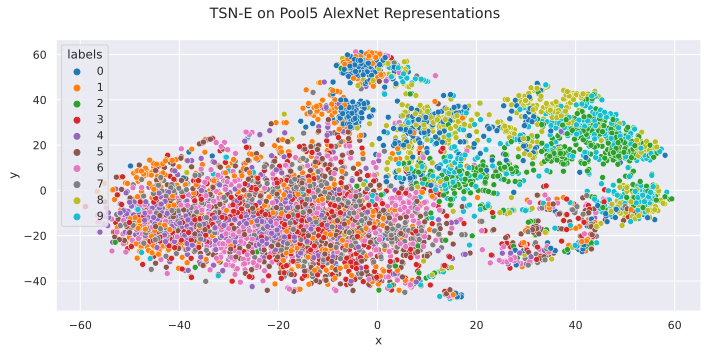

In [16]:
df = {
    'x': projected_encodings[:, 0],
    'y': projected_encodings[:, 1],
    'labels': encoded_labels
}

fig = plt.figure(figsize=(10, 5))
fig.suptitle('TSN-E on Pool5 AlexNet Representations')
sns.scatterplot(data=df, x='x', y='y', hue='labels', palette='tab10')

plt.tight_layout()

In [17]:
fig.savefig(f'/kaggle/working/tsne-{perplexity}-{n_iter}.svg')

In [91]:
download_file(f'/kaggle/working/tsne-{perplexity}-{n_iter}.svg', 'tsne')

Unable to run zip command!



In [ ]:
class0 = []
class2 = []
class8 = []
class9 = []

class_other = []

for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

    img, labels = batch['image'], batch['label']
    class0 += list(np.array(img)[labels == 0])
    class2 += list(np.array(img)[labels == 2])
    class8 += list(np.array(img)[labels == 8])
    class9 += list(np.array(img)[labels == 9])
    
    class_other += list(np.array(img)[torch.isin(labels, torch.tensor([1, 3, 4, 5, 6, 7]))])

In [37]:
import random

random.shuffle(class0)
random.shuffle(class2)
random.shuffle(class8)
random.shuffle(class9)

random.shuffle(class_other)

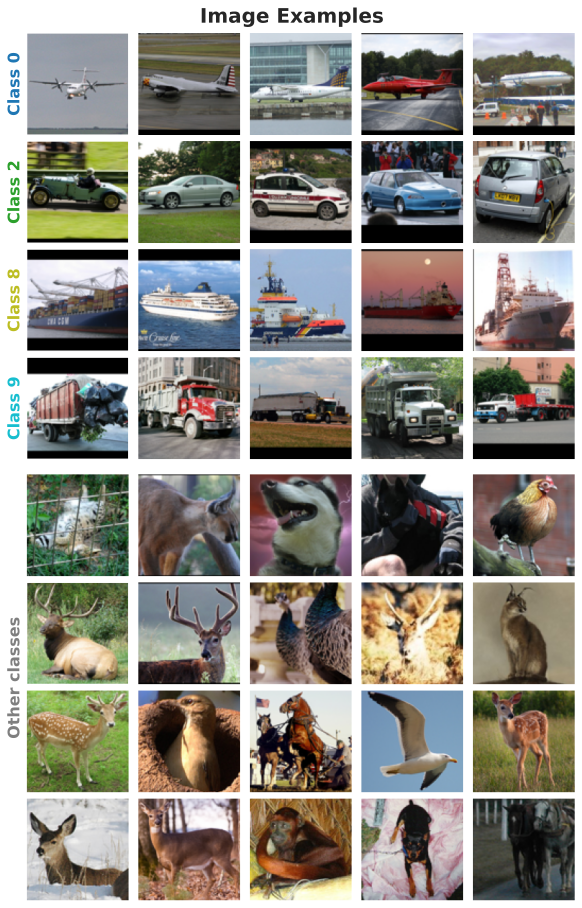

In [134]:
images_iter = iter(class0[:5] + class2[:5] + class8[:5] + class9[:5] + class_other[:20])
colors = iter(np.array(sns.color_palette('tab10').as_hex())[[0, 2, 8, 9, 7]])

fig = plt.figure(layout='constrained', figsize=(8, 12.5))
plt.suptitle('Image Examples', weight='bold', fontsize=20)

subfigs = fig.subfigures(2, 1)

for i in range(20):
    ax = subfigs[0].add_subplot(4, 5, i+1)
    ax.imshow(next(images_iter))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i == 0:
        plt.ylabel('Class 0', color=next(colors), weight='bold', fontsize=16)
    elif i == 5:
        plt.ylabel('Class 2', color=next(colors), weight='bold', fontsize=16)
    elif i == 10:
        plt.ylabel('Class 8', color=next(colors), weight='bold', fontsize=16)
    elif i == 15:
        plt.ylabel('Class 9', color=next(colors), weight='bold', fontsize=16)
    else:
        plt.axis('off')
        
for i in range(20):
    ax = subfigs[1].add_subplot(4, 5, i+1)
    ax.imshow(next(images_iter))

    ax.set_xticks([])
    ax.set_yticks([])

    if i == 5:
        plt.ylabel('Other classes                ', color=next(colors), weight='bold', fontsize=16)
    else:
        plt.axis('off')

In [135]:
fig.savefig(f'/kaggle/working/images.svg')

## Experiments

### Sum cross-channel representations from Pool5

In [9]:
class SumClassifier(nn.Module):

    def __init__(self, sbae_weights_path: str, last_layer_ind: int = 17, input_size: int = 6*6*256,
                 n_classes: int = 10, hidden_size: int = 1000, downsample_size: int = 6, **kwargs) -> None:
        super().__init__()

        # pretrained SplitBrainAE
        self.sb_ae = SBAutoEncoder(**kwargs)
        self.sb_ae.load_state_dict(torch.load(sbae_weights_path))

        # freezing weights
        for param in self.sb_ae.parameters():
            param.requires_grad = False
                                                                        
        self.last_layer_ind = last_layer_ind
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)

        # fc classification head
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, n_classes),
        )

    def forward(self, x: torch.tensor):
        x1, x2 = x[:, 0, :, :].unsqueeze(1), x[:, 1:, :, :]

        # slicing specified number of layers
        x2_hat = self.sb_ae.L_ab.fc_encoder[:self.last_layer_ind+1](x1)                 # [batch, N, 12, 12]
        x1_hat = self.sb_ae.ab_L.fc_encoder[:self.last_layer_ind+1](x2)                 # [batch, N, 12, 12]

        x = x1_hat + x2_hat                                                             # [batch, N, 12, 12]
        x = self.resize(x).view(x.shape[0], -1)                                         # [batch, N * 5 * 5]

        x = self.fc(x)                                                                  # [batch, 10]

        return x

### Concatenate summed representations from Conv3 and Pool5

In [18]:
class ConcatClassifier(nn.Module):

    def __init__(self, sbae_weights_path: str, last_layer_ind: list = [8, 17], input_size: int = 5*5*(384+256),
                 n_classes: int = 10, hidden_size: int = 1000, downsample_size: int = 5, **kwargs) -> None:
        super().__init__()

        # pretrained SplitBrainAE
        self.sb_ae = SBAutoEncoder(**kwargs)
        self.sb_ae.load_state_dict(torch.load(sbae_weights_path))

        # freezing weights
        for param in self.sb_ae.parameters():
            param.requires_grad = False
                                                                        
        self.last_layer_ind = last_layer_ind
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)

        # fc classification head
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, n_classes),
        )

    def forward(self, x: torch.tensor):
        x1, x2 = x[:, 0, :, :].unsqueeze(1), x[:, 1:, :, :]

        # slicing specified number of layers
        x2_shallow = self.sb_ae.L_ab.fc_encoder[:self.last_layer_ind[0]+1](x1)             # [batch, 384, 12, 12]
        x1_shallow = self.sb_ae.ab_L.fc_encoder[:self.last_layer_ind[0]+1](x2)             # [batch, 384, 12, 12]
        
        x2_deep = self.sb_ae.L_ab.fc_encoder[self.last_layer_ind[0]+1: self.last_layer_ind[1]+1](x2_shallow)      # [batch, 256, 12, 12]
        x1_deep = self.sb_ae.ab_L.fc_encoder[self.last_layer_ind[0]+1: self.last_layer_ind[1]+1](x1_shallow)      # [batch, 256, 12, 12]

        x_shallow = x1_shallow + x2_shallow                                                # [batch, 384, 12, 12]
        x_deep = x1_deep + x2_deep                                                         # [batch, 256, 12, 12]
        
        x = torch.cat((x_shallow, x_deep), dim=1)                                          # [batch, 384+256, 12, 12]
        x = self.resize(x).view(x.shape[0], -1)                                            # [batch, 384+256 * 5 * 5]
        x = self.fc(x)                                                                     # [batch, 10]

        return x

In [19]:
n_epochs = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConcatClassifier(sbae_weights_path='/kaggle/input/split-brain-pretrained/pretrained_ae/sb_encoder-4.pth').to(device).train()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 146774229


In [20]:
total_step = 0

train_loss = []
val_loss = 0

train_accuracy = []
val_accuracy = 0

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        X, labels = batch['train'].to(device), batch['label'].to(device)

        # Perform forward pass
        logits = model(X)
        loss = criterion(logits, labels)

        # Perform backward pass
        loss.backward()
        
        # Compute accuracy
        with torch.no_grad():
            preds = torch.argmax(logits, dim=-1)

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            train_accuracy.append(torch.mean((preds == labels).float()).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            train_accuracy[(total_step - 1) % 100] = torch.mean((preds == labels).float()).item()

        # Perform Optimization Step
        optimizer.step()

        # validation
        if total_step % 30 == 0:

            val_loss = 0
            val_accuracy = 0
            model.eval()

            with torch.no_grad():
                for val_batch in val_dl:
                    X, labels = val_batch['train'].to(device), val_batch['label'].to(device)
                    logits = model(X)
                    preds = torch.argmax(logits, dim=-1)
                    val_loss += criterion(logits, labels)
                    val_accuracy += torch.mean((preds == labels).float()).item()
                
                val_loss /= len(val_dl)
                val_accuracy /= len(val_dl)

                # saving logs
                writer.add_scalar('Loss/Val', val_loss, global_step=total_step)
                writer.add_scalar('Accuracy/Val', val_accuracy, global_step=total_step)

            model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, Accuracy Train/Val: {1:.2f}/{2:.2f}, Loss Train/Val: {3:.2f}/{4:.3f}'.format(
                current_lr, np.mean(train_accuracy), val_accuracy, np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('Accuracy/Train', np.mean(train_accuracy), global_step=total_step)
    
    # saving model
    if epoch == 4:
        torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'sb_encoder-{epoch}.pth'))

    writer.flush()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [22]:
download_file('/kaggle/working/logs', 'logs')

/kaggle/working/logs.zip

In [23]:
download_file('/kaggle/working/model_checkpoints', 'out')

/kaggle/working/out.zip

### Triple-Brain AE

In [9]:
class TripleDataset(STLDataset):

    def __init__(self, root: str, preprocess: Callable, downsample_size: int,
                 L_bins: int, ab_bins: int, split: str = 'unlabeled') -> None:
        super().__init__(root, preprocess, downsample_size, L_bins, ab_bins, split)
    
    def __getitem__(self, index: int) -> Any:

        image, label = self.stl_dataset[index]                  # RGB: (3, H, W)
        preprocessed = self.preprocess(image)                   # LAB: (3, H, W)

        # normalized train image
        normalized = self.normalize_lab(preprocessed)

        if self.requires_downsample:

            # downsampling original image
            downsample = self.resize(preprocessed)                  # LAB: (3, D, D)

            # bucketizing
            # L in [0, 100]
            # a in [-87, 99]
            # b in [-108, 95]
            L_target = torch.bucketize(downsample[0, :, :], boundaries=torch.linspace(0, 101, self.L_bins+1), right=True) - 1
            a_target = torch.bucketize(downsample[1, :, :], boundaries=torch.linspace(-87, 99, self.ab_bins+1), right=True) - 1
            b_target = torch.bucketize(downsample[2, :, :], boundaries=torch.linspace(-108, 95, self.ab_bins+1), right=True) - 1

            ds_elem = {
                'image': image,
                'train': normalized,
                'L_target': L_target.type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor),
                'a_target': a_target.type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor),
                'b_target': b_target.type(torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor)
            }
            return ds_elem

        ds_elem = {
            'image': image,
            'label': label,
            'train': normalized,
        }
        return ds_elem
    
def collate_fn_triple(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    data = {}
    data['image'] = [elem['image'] for elem in batch]
    data['train'] = torch.stack([elem['train'] for elem in batch])
    data['L_target'] = torch.stack([elem['L_target'] for elem in batch])
    data['a_target'] = torch.stack([elem['a_target'] for elem in batch])
    data['b_target'] = torch.stack([elem['b_target'] for elem in batch])
    return data

In [10]:
class TripleBrain(nn.Module):

    def __init__(self, L_bins: int = 100, ab_bins: int = 25) -> None:
        super().__init__()
        self.ab_L = AlexNetEncoder(2, L_bins)
        self.La_b = AlexNetEncoder(2, ab_bins)
        self.Lb_a = AlexNetEncoder(2, ab_bins)

        print(f'Split Brain Num params: {sum(p.numel() for p in self.parameters() if p.requires_grad)}')
    
    def forward(self, x: torch.tensor):
        '''
        :x: torch.tensor of shape [batch, 3, 96, 96]
        '''
        x1, x2, x3 = x[:, 1:, :, :], x[:, :2, :, :], x[:, ::2, :, :]                        # [batch, 2, 96, 96]
        
        L_hat = self.ab_L(x1)
        b_hat = self.La_b(x2)   
        a_hat = self.Lb_a(x3)

        return L_hat, a_hat, b_hat

In [8]:
triple_dataset = TripleDataset(root, preprocess, downsample_size=12, L_bins=100, ab_bins=25)
train_ds, val_ds = torch.utils.data.random_split(triple_dataset, [0.9, 0.1])

train_dl = DataLoader(train_ds, 64, shuffle=True, collate_fn=collate_fn_triple)
val_dl = DataLoader(val_ds, 64, shuffle=False, collate_fn=collate_fn_triple)

100%|██████████| 2640397119/2640397119 [01:07<00:00, 39079891.61it/s]


Extracting /kaggle/working/stl10_binary.tar.gz to /kaggle/working


In [9]:
! rm -rf /kaggle/working/model_checkpoints
! rm -rf /kaggle/working/logs

In [10]:
model_checkpoint_path = os.path.join(os.getcwd(), 'model_checkpoints')

if not os.path.exists(model_checkpoint_path):
    os.mkdir(model_checkpoint_path)

In [18]:
n_epochs = 5
max_norm = 0.5  # gradient clipping

device = torch.device('cuda:0')

model = torch.nn.DataParallel(TripleBrain()).to(device).train()

scaler = torch.cuda.amp.GradScaler()

L_criterion = nn.CrossEntropyLoss()
a_criterion = nn.CrossEntropyLoss()
b_criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.8)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 216334806


In [ ]:
total_step = 0

train_loss = []
val_loss = 0
grad_norm = []

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        X, L_target, a_target, b_target = batch['train'], batch['L_target'].to(device), \
                                          batch['a_target'].to(device), batch['b_target'].to(device)

        # Perform forward pass with mixed precision
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            
            # predictions
            L_hat, a_hat, b_hat = model(X)
            
            # compute losses
            L_loss = L_criterion(L_hat, L_target)
            a_loss = a_criterion(a_hat, a_target)
            b_loss = b_criterion(b_hat, b_target)
            
            loss = L_loss + a_loss + b_loss

        # Perform backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            # Perform Gradient Clipping
            grad_norm.append(torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            grad_norm[(total_step - 1) % 100] = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm).item()

        # Perform Optimization Step
        scaler.step(optimizer)
        scaler.update()

        # Perform Scheduler Step
        scheduler.step()
        current_lr = scheduler.get_last_lr()[-1]

        # validation
        if total_step % 300 == 0:

            val_loss = 0
            model.eval()

            with torch.no_grad():
                for val_batch in val_dl:
                    X, L_target, a_target, b_target = val_batch['train'], val_batch['L_target'].to(device), \
                                                      val_batch['a_target'].to(device), val_batch['b_target'].to(device)
                    L_hat, a_hat, b_hat = model(X)
                    val_loss += (L_criterion(L_hat, L_target) + a_criterion(a_hat, a_target) + b_criterion(b_hat, b_target)).item()
                
                val_loss /= len(val_dl)

                # saving logs
                writer.add_scalar('Loss/Val', val_loss, global_step=total_step)

            model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, GradNorm: {1:.2e}, Loss Train/Val: {2:.2e}/{3:.3e}'.format(
                current_lr, np.mean(grad_norm), np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('GradNorm', np.mean(grad_norm), global_step=total_step)
    
    # saving model
    torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'triple_brain-{epoch}.pth'))

    writer.flush()

### Classifier on Triple-Brain AE

In [11]:
class SumClassifier(nn.Module):

    def __init__(self, sbae_weights_path: str, last_layer_ind: int = 17, input_size: int = 6*6*256,
                 n_classes: int = 10, hidden_size: int = 1000, downsample_size: int = 6, **kwargs) -> None:
        super().__init__()

        # pretrained SplitBrainAE
        self.sb_ae = torch.nn.DataParallel(TripleBrain(**kwargs))
        self.sb_ae.load_state_dict(torch.load(sbae_weights_path))

        # freezing weights
        for param in self.sb_ae.parameters():
            param.requires_grad = False
                                                                        
        self.last_layer_ind = last_layer_ind
        self.resize = transforms.Resize(size=[downsample_size]*2, antialias=None)

        # fc classification head
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, n_classes),
        )

    def forward(self, x: torch.tensor):
        x1, x2, x3 = x[:, 1:, :, :], x[:, :2, :, :], x[:, ::2, :, :]                    # [batch, 2, 96, 96]

        # slicing specified number of layers

        L_hat = self.sb_ae.module.ab_L.fc_encoder[:self.last_layer_ind+1](x1)           # [batch, N, 12, 12]
        b_hat = self.sb_ae.module.La_b.fc_encoder[:self.last_layer_ind+1](x2)           # [batch, N, 12, 12]
        a_hat = self.sb_ae.module.Lb_a.fc_encoder[:self.last_layer_ind+1](x3)           # [batch, N, 12, 12]

        x = L_hat + b_hat + a_hat                                                       # [batch, N, 12, 12]
        x = self.resize(x).view(x.shape[0], -1)                                         # [batch, N * 5 * 5]

        x = self.fc(x)                                                                  # [batch, 10]

        return x

In [12]:
device = torch.device('cuda:0')

model = SumClassifier(sbae_weights_path='/kaggle/input/triple-brain/triple_brain-0.pth').to(device).train()
n_epochs = 5

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

current_lr = scheduler.get_last_lr()[-1]

writer = SummaryWriter(log_dir='./logs')

Split Brain Num params: 216334806


In [13]:
total_step = 0

train_loss = []
val_loss = 0

train_accuracy = []
val_accuracy = 0

for epoch in tqdm.tqdm(range(n_epochs)):

    for batch in (pbar := tqdm.tqdm(train_dl, total=len(train_dl))):

        total_step += 1

        # Clear gradients
        optimizer.zero_grad()
        
        # Move tensors to device
        X, labels = batch['train'].to(device), batch['label'].to(device)

        # Perform forward pass
        logits = model(X)
        loss = criterion(logits, labels)

        # Perform backward pass
        loss.backward()
        
        # Compute accuracy
        with torch.no_grad():
            preds = torch.argmax(logits, dim=-1)

        # Averaging over sliding window
        if len(train_loss) < 100:
            train_loss.append(loss.item())
            train_accuracy.append(torch.mean((preds == labels).float()).item())
        else:
            train_loss[(total_step - 1) % 100] = loss.item()
            train_accuracy[(total_step - 1) % 100] = torch.mean((preds == labels).float()).item()

        # Perform Optimization Step
        optimizer.step()

        # validation
        if total_step % 30 == 0:

            val_loss = 0
            val_accuracy = 0
            model.eval()

            with torch.no_grad():
                for val_batch in val_dl:
                    X, labels = val_batch['train'].to(device), val_batch['label'].to(device)
                    logits = model(X)
                    preds = torch.argmax(logits, dim=-1)
                    val_loss += criterion(logits, labels)
                    val_accuracy += torch.mean((preds == labels).float()).item()
                
                val_loss /= len(val_dl)
                val_accuracy /= len(val_dl)

                # saving logs
                writer.add_scalar('Loss/Val', val_loss, global_step=total_step)
                writer.add_scalar('Accuracy/Val', val_accuracy, global_step=total_step)

            model.train()

        # update tqdm info
        pbar.set_description(
            'Lr: {0:.2e}, Accuracy Train/Val: {1:.2f}/{2:.2f}, Loss Train/Val: {3:.2f}/{4:.3f}'.format(
                current_lr, np.mean(train_accuracy), val_accuracy, np.mean(train_loss), val_loss
            )
        )

        # saving logs
        writer.add_scalar('Loss/Train', np.mean(train_loss), global_step=total_step)
        writer.add_scalar('Accuracy/Train', np.mean(train_accuracy), global_step=total_step)
    
    # saving model
    if epoch == 4:
        torch.save(model.state_dict(), os.path.join(model_checkpoint_path, f'sb_encoder-{epoch}.pth'))

    writer.flush()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]